# Analysis I

### Context

A cliente asks us for investment advice. This client has been thought to invest on stock market, mainly on S&P500. They want to invest on Energy sector, however they do not know what is the best sub-industry or company to invest on, or whether the Energy sector it is the best sector to do it. Beside, they want to know whether or not make long or short-term investments.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
# from functools import reduce

In [2]:
# ETL file
from get_dataset import Finance
from get_dataset import Returns_Risk
F = Finance()

In [3]:
# sns.set_style('whitegrid')
# plt.style.use("fivethirtyeight")

So in order to analyse the Stock Market we bring in the table of companies belonging to S&P500 from wikipedia

In [4]:
# bring in the companies in S&P500
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


Moreover, we import the file *get_dataset.py*  which help us with the ETL of the dataset related to the important features for this analysis. The dataset is download through the python library *yfinance*, this can be visualized in detail in the script for ETL.

### Adjusted Close & Returns by Sector

Now, we start by analyzing the market by sector. For this purpouse, we work with the 'adjusted' closing values for each company. 

In [5]:
# let's see what sector is in S&P500
sectors = F.get_sector()
sectors

['Industrials',
 'Health Care',
 'Information Technology',
 'Communication Services',
 'Consumer Staples',
 'Consumer Discretionary',
 'Utilities',
 'Financials',
 'Materials',
 'Real Estate',
 'Energy']

The file *get_dataset* has two function named *adj_close_mean_sector* which gives us the average on adjusted close for the companies in each sector, and *Returns_Risk* which brings in two dataframes one with the mean returns and another one with features to analyse risk on investments.

In [6]:
# let's bring in them
df_adj_close = F.adj_close_mean_sector()
df_adj_close.index = pd.to_datetime(df_adj_close.index).date
df_adj_close.tail()

,Industrials,Health Care,Information Technology,Communication Services,Consumer Staples,Consumer Discretionary,Utilities,Financials,Materials,Real Estate,Energy
2023-03-20,12093.779983,14495.292787,12928.149972,2064.459995,4091.732899,18318.975825,2127.730000,9415.990017,3402.111691,3557.144731,1736.620012
2023-03-21,12249.870019,14677.828995,13092.849998,2094.820019,4093.458141,18491.890183,2078.969991,9648.740042,3456.214096,3534.093481,1792.269985
2023-03-22,12025.419973,14394.299984,12876.219929,2046.189990,4051.890018,18236.709798,2034.299985,9418.539980,3383.429963,3405.591049,1754.290018
2023-03-23,11976.629989,14379.299966,13089.589998,2091.660008,4037.099995,18083.740230,2013.950013,9350.830025,3376.130009,3387.866996,1731.219995
2023-03-24,12024.520020,14579.000032,13018.859985,2108.000011,4102.080006,18115.279984,2079.770005,9371.849960,3405.199986,3471.640031,1737.709982


In [7]:
# first let's create a mask to limit the dateset
start = '2000/01/01'
mask = (df_adj_close.index > pd.to_datetime(start).date())
df_adj_close = df_adj_close.loc[mask]
df_adj_close.head()

,Industrials,Health Care,Information Technology,Communication Services,Consumer Staples,Consumer Discretionary,Utilities,Financials,Materials,Real Estate,Energy
2000-01-03,915.991266,717.927554,1636.013062,201.628798,430.253555,755.040026,239.595125,1910.666416,331.562529,213.948445,158.911198
2000-01-04,892.227527,694.415959,1545.528111,192.318820,419.458808,759.547018,240.809859,1819.018848,325.103599,211.206198,156.864587
2000-01-05,897.275991,701.032683,1515.443232,191.827347,417.994938,799.597082,249.359221,1822.812065,335.301506,211.343908,158.553105
2000-01-06,910.813638,709.358471,1397.242760,185.786180,422.742504,781.741181,250.007611,1877.372242,346.173080,213.333068,166.471195
2000-01-07,932.933267,760.783273,1459.049216,189.266176,439.946032,788.999408,253.057184,1956.993138,351.422574,219.957744,170.082119


In [8]:
# this function allows two arguments, first a dataframe of adjusted closing price
# and a time type ('Year', 'Month', 'Week')
time_type = 'year'
df_returns, risk = Returns_Risk(df_adj_close, time_type)
df_returns.head()

,Industrials,Health Care,Information Technology,Communication Services,Consumer Staples,Consumer Discretionary,Utilities,Financials,Materials,Real Estate,Energy
year,,,,,,,,,,,
2000,14.84,58.20,-31.94,-16.87,8.34,-29.20,41.36,39.58,-3.27,109.07,45.98
2001,2.88,-4.42,-10.14,6.44,7.20,47.25,-12.07,-7.22,10.58,-15.44,-13.12
2002,-12.08,-16.93,-35.71,-17.02,-4.30,9.78,-13.29,-18.18,1.63,-23.88,-2.13
2003,26.80,28.75,50.80,39.36,17.35,40.71,28.07,26.52,26.41,41.04,27.24
2004,21.03,17.23,17.02,16.43,19.07,39.16,19.47,10.50,17.34,38.23,31.43


In [9]:
risk

,Sector,Expected Return,Volatility,Total Return
0,Industrials,0.053411,1.365944,312.08
1,Health Care,0.059524,1.260705,347.80
2,Information Technology,0.053635,1.905158,313.39
3,Communication Services,0.051877,1.530087,303.12
4,Consumer Staples,0.043230,0.968300,252.59
5,Consumer Discretionary,0.067378,1.607918,393.69
6,Utilities,0.044595,1.233735,260.57
7,Financials,0.040755,1.647828,238.13
8,Materials,0.051123,1.495652,298.71
9,Real Estate,0.069125,2.284037,403.90


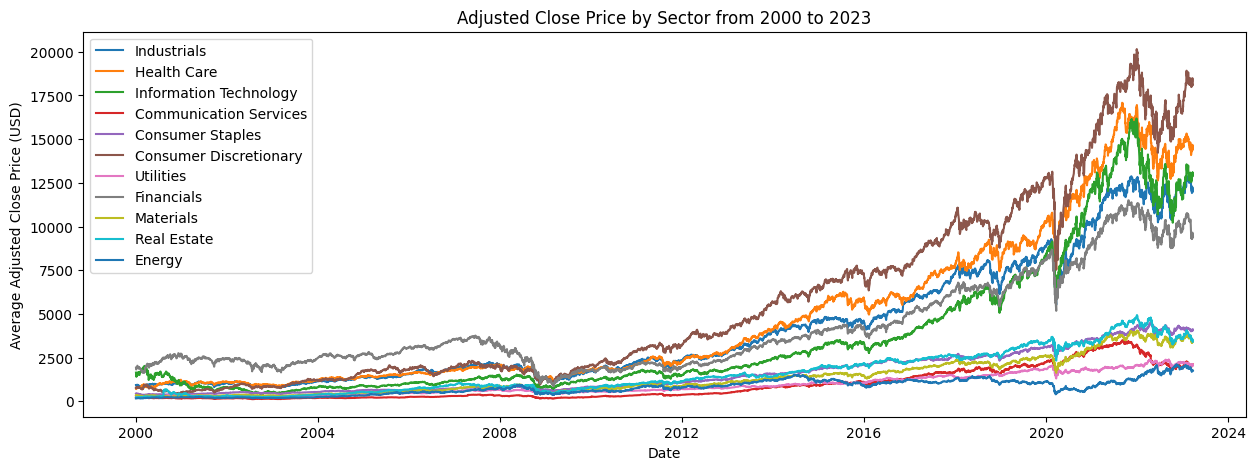

In [10]:
plt.figure(figsize=(15,5))
for c in df_adj_close.columns:
    sns.lineplot(x='index', y=c, data=df_adj_close[[c]].reset_index(), label=c)
plt.xlabel('Date')
plt.ylabel('Average Adjusted Close Price (USD)')
plt.title('Adjusted Close Price by Sector from {} to {}' \
          .format(df_adj_close.index.min().year, df_adj_close.index.max().year))
plt.legend()
plt.show()

Here we can appreciate the adjusted closing price (USD) for every sector. The greatest close price are in **Consumer Discretionary**, **Health Care**, **Information Technology** and **Industrials**, and the lowest are in **Energy** and **Utilities** sectors. But this privides us no enough information to take a decision.

### Volatility by Sector

So to expand the analysis and then find out whether we recommend to our client to invest on Energy sector we analyse the returns and volatility of each stock.

So we are going to deal the *df_return* and *risk* dataframes with.

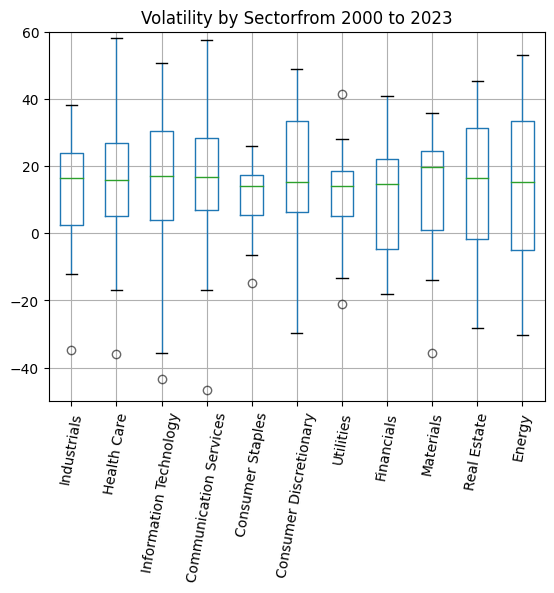

In [11]:
# A fast way to visuality the stock's volatility in market is to perform a boxplot on returns data
plt.figure()
df_returns.boxplot(flierprops={'alpha': 0.6})
plt.ylim([-50,60])
plt.xticks(rotation=80)
plt.title('Volatility by Sectorfrom {} to {}' \
          .format(df_adj_close.index.min().year, df_adj_close.index.max().year))
plt.show()

Throughoout the last 23 years, sectors such as **Energy** and **Information Technology** has had a volatility greater than others. A high volatility indicates that the stock's price is experiencing large swings, which can be either positive or negative, this means that the stock is considered more risky, so we can get large gains or losses.

On the other hand there are actually more methods to visualize the volatility by performing the Beta Method and Standard Deviation Method, for instance.

#### Standard Deviation Method

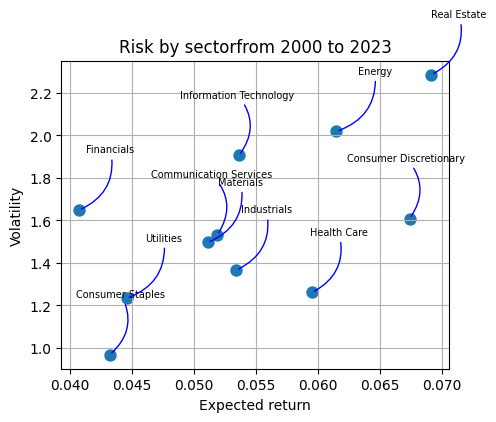

In [12]:
plt.figure(figsize=(5, 4))
area = np.pi * 20
plt.scatter(risk['Expected Return'].values, risk['Volatility'].values, s=area)
plt.xlabel('Expected return', fontsize=10)
plt.ylabel('Volatility', fontsize=10)

for label, x, y in zip(sectors, risk['Expected Return'].values, risk['Volatility'].values):
    plt.annotate(label, xy=(x, y), xytext=(40, 40), textcoords='offset points', ha='right', va='bottom', fontsize=7,
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.4'))
    
plt.tick_params(labelsize=10)
plt.title('Risk by sectorfrom {} to {}' \
          .format(df_adj_close.index.min().year, df_adj_close.index.max().year))
plt.grid()
plt.show()

This time we compare the volatility vs expected return, we can appreciate again **Information Technology** and **Energy** sectors has great volatility, however has appear other sector **Real Estate** which has the greatest risk in market.

#### Beta Parameter

Beta parameter measures how much a sector's returns move in relation to the returns of the overall market. A sector with a beta greater than 1 is more volatile than the market, while a beta less than 1 is less volatile than the market. A negative beta indicates that the sector moves in the opposite direction of the market.

In [13]:
# for such purpose we create the global market as the mean return of all stocks
global_market = pd.DataFrame(df_returns.mean(axis=1), columns=['Global Return'])
global_market.tail()

,Global Return
year,
2019,29.945455
2020,19.639091
2021,26.856364
2022,-8.390000
2023,0.573636


In [14]:
merge = pd.merge(df_returns, global_market, left_index=True, right_index=True).dropna()
merge.head()

,Industrials,Health Care,Information Technology,Communication Services,Consumer Staples,Consumer Discretionary,Utilities,Financials,Materials,Real Estate,Energy,Global Return
year,,,,,,,,,,,,
2000,14.84,58.20,-31.94,-16.87,8.34,-29.20,41.36,39.58,-3.27,109.07,45.98,21.462727
2001,2.88,-4.42,-10.14,6.44,7.20,47.25,-12.07,-7.22,10.58,-15.44,-13.12,1.085455
2002,-12.08,-16.93,-35.71,-17.02,-4.30,9.78,-13.29,-18.18,1.63,-23.88,-2.13,-12.010000
2003,26.80,28.75,50.80,39.36,17.35,40.71,28.07,26.52,26.41,41.04,27.24,32.095455
2004,21.03,17.23,17.02,16.43,19.07,39.16,19.47,10.50,17.34,38.23,31.43,22.446364


In [15]:
beta = []
for c in merge.columns[:-1]:
    y = merge[c]
    X = sm.add_constant(merge['Global Return'])
    model = sm.OLS(y, X)
    results = model.fit()
    beta.append(results.params['Global Return'])

range = np.arange(len(df_returns.columns))
beta = {ii: [c, b] for (ii, c, b) in zip(range, df_returns.columns, beta)}
beta = pd.DataFrame(beta, index=['Sector', 'Beta']).T
beta

,Sector,Beta
0,Industrials,0.988892
1,Health Care,1.050836
2,Information Technology,1.311754
3,Communication Services,1.332273
4,Consumer Staples,0.579578
5,Consumer Discretionary,0.888164
6,Utilities,0.650952
7,Financials,1.321566
8,Materials,0.93538
9,Real Estate,1.122252


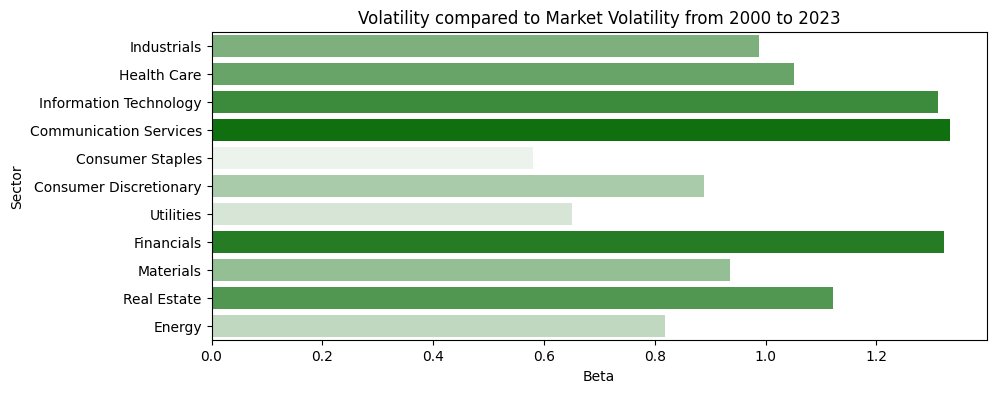

In [16]:
plt.figure(figsize=(10,4))
cmap = sns.color_palette("light:g", beta.shape[0])
rank = beta['Beta'].values.argsort().argsort() 
sns.barplot(x='Beta', y='Sector', data=beta, palette=np.array(cmap)[rank])
plt.title('Volatility compared to Market Volatility from {} to {}' \
          .format(df_adj_close.index.min().year, df_adj_close.index.max().year))
plt.show()

Here we can appreciate than **Information Technology**, **Communication Services**  and **Financial** have greater volatility than the global one. Otherwise **Consumer Staples** and **Utilities** have low volatility compared to the global one. 

### Total Returns by Sector

Let's see the Total Return over the period of time selected for every sector.

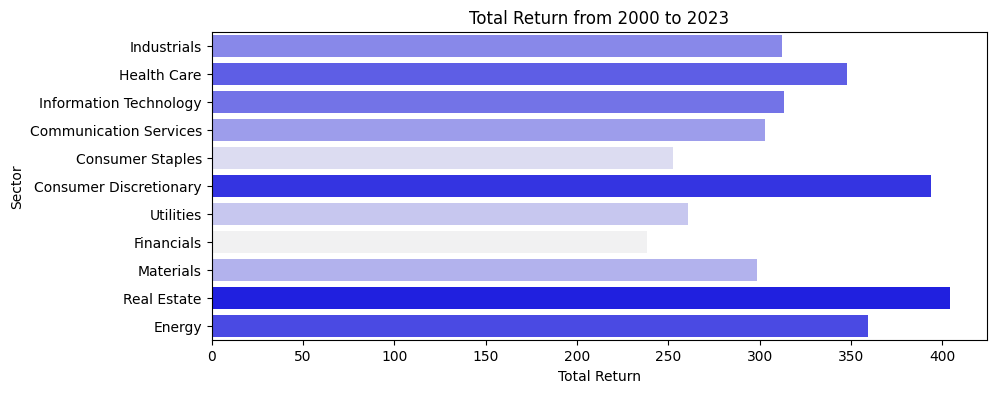

In [17]:
plt.figure(figsize=(10,4))
cmap = sns.color_palette("light:b", risk.shape[0])
rank = risk['Total Return'].values.argsort().argsort() 
sns.barplot(x='Total Return', y='Sector', data=risk, palette=np.array(cmap)[rank])
plt.title('Total Return from {} to {}' \
          .format(df_adj_close.index.min().year, df_adj_close.index.max().year))
plt.show()

For the date range chosen (2000-2023) the sectors with the greatest total returns are **Real Estate**, **Energy** and **Health Care**.
However, for the range (2010-2023) are the same.

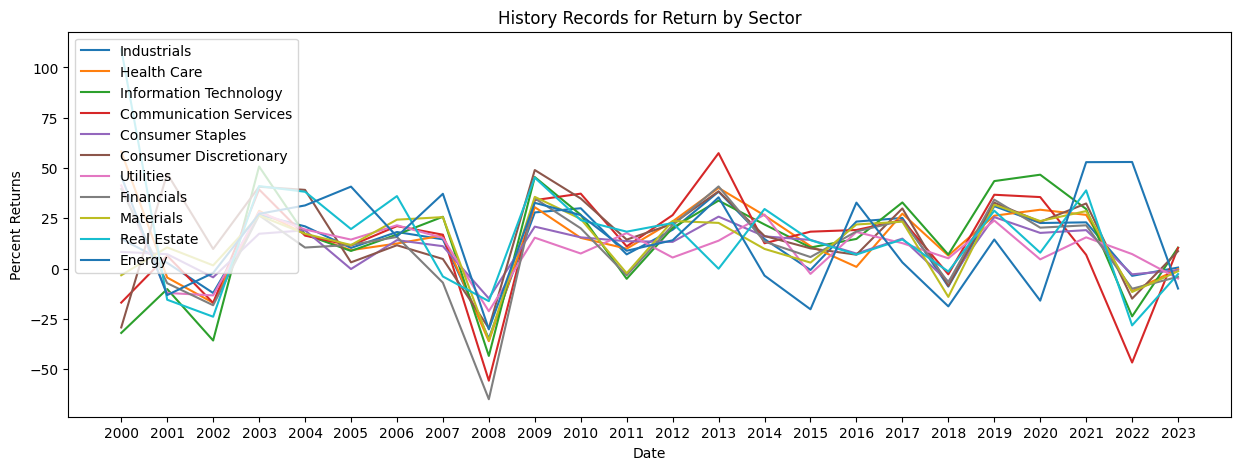

In [18]:
plt.figure(figsize=(15,5))
for c in df_returns.columns:
    sns.lineplot(x=time_type, y=c, data=df_returns[[c]], label=c)

plt.xlabel('Date')
plt.ylabel('Percent Returns')
plt.title('History Records for Return by Sector')
plt.show()

In the previous figure, we can see the returns along 23 years, where in 2008 returns dips than any year, this was caused by the crunch in that year.